In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/MyDrive/LOBster'

os.chdir(path)

Mounted at /content/drive


Epoch 1/100
273/273 [==============================] - 34s 104ms/step - loss: 0.1862 - mape: 80.0570 - root_mean_squared_error: 0.4315 - val_loss: 0.0743 - val_mape: 79.4292 - val_root_mean_squared_error: 0.2726
Epoch 2/100
273/273 [==============================] - 29s 105ms/step - loss: 0.1213 - mape: 69.0152 - root_mean_squared_error: 0.3482 - val_loss: 0.0689 - val_mape: 70.4525 - val_root_mean_squared_error: 0.2626
Epoch 3/100
273/273 [==============================] - 30s 108ms/step - loss: 0.1120 - mape: 64.5535 - root_mean_squared_error: 0.3347 - val_loss: 0.0734 - val_mape: 72.5936 - val_root_mean_squared_error: 0.2709
Epoch 4/100
273/273 [==============================] - 30s 108ms/step - loss: 0.1072 - mape: 62.8601 - root_mean_squared_error: 0.3274 - val_loss: 0.0693 - val_mape: 67.5073 - val_root_mean_squared_error: 0.2633
Epoch 5/100
273/273 [==============================] - 30s 109ms/step - loss: 0.1035 - mape: 61.9554 - root_mean_squared_error: 0.3217 - val_loss: 0.068

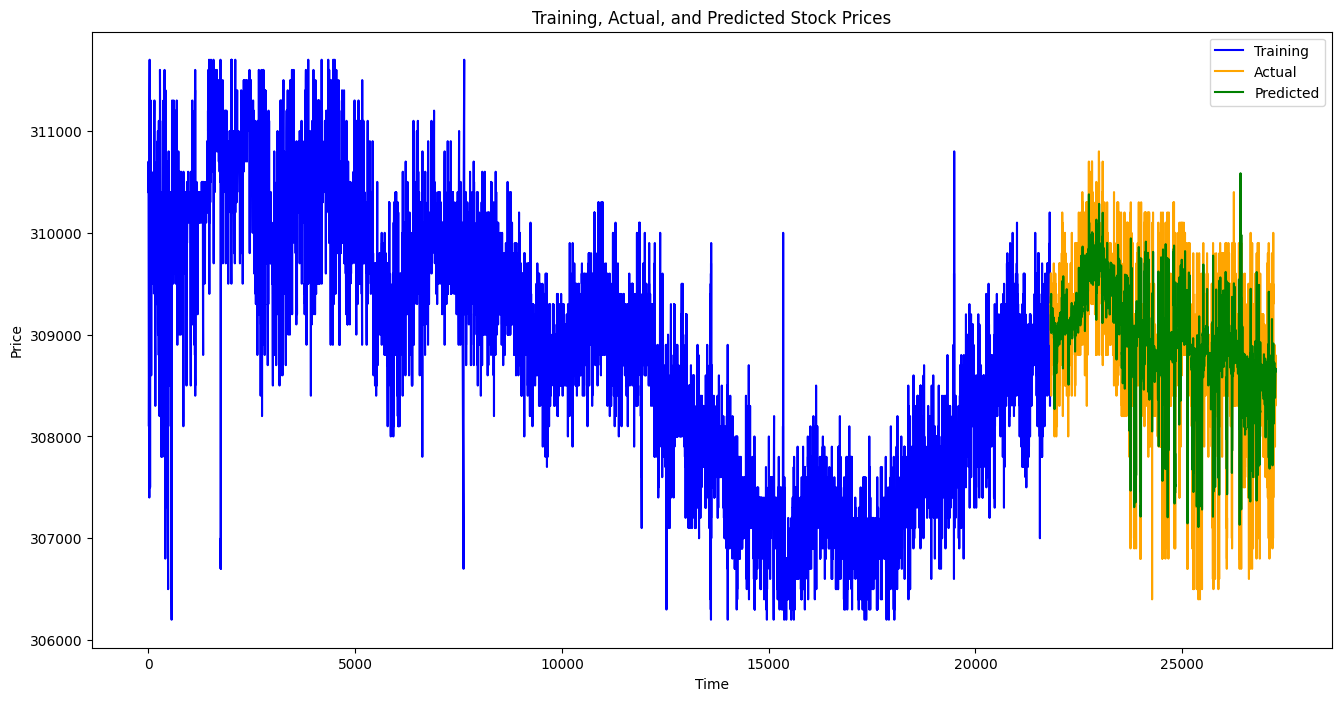

RMSE: 481.8400360889269
MAPE: 0.0010348702898372994


In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Read the data
df = pd.read_csv('MSFT/data_msft_ta.csv')
data = df.filter(['Price', 'OFI'])
data.dropna(inplace=True)
dataset = data.values

training_data_len = math.ceil(len(dataset) * 0.8)

scaler_price = StandardScaler()
scaler_ofi = StandardScaler()

scaled_price = scaler_price.fit_transform(dataset[:, 0].reshape(-1, 1))
scaled_ofi = scaler_ofi.fit_transform(dataset[:, 1].reshape(-1, 1))

scaled_data = np.concatenate((scaled_price, scaled_ofi), axis=1)

train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

x_train = []
y_train = []

for i in range(10, len(train_data)):
    x_train.append(train_data[i-10:i, :])  # Use both Price and OFI columns as input
    y_train.append(train_data[i, 0])  # Use the 1st column (Price) as the target

x_train, y_train = np.array(x_train), np.array(y_train)

model = Sequential()
model.add(LSTM(units=124, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(layers.Dropout(0.2))
model.add(LSTM(units=104, activation='relu', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(LSTM(units=128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(Dense(units=68, activation='relu'))
model.add(Dense(units=1, activation='linear'))

optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss, metrics=['mape', tf.keras.metrics.RootMeanSquaredError()])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit the model with EarlyStopping callback
model.fit(x_train, y_train, batch_size=64, epochs=100, callbacks=[early_stopping], validation_split=0.2)

x_test = []
y_test = []

for i in range(10, len(test_data)):
    x_test.append(test_data[i-10:i, :])  # Use both Price and OFI columns as input
    y_test.append(test_data[i, 0])  # Use the 1st column (Price) as the target

x_test = np.array(x_test)

predictions = model.predict(x_test)

# Inverse transform the predictions and y_test
predictions = scaler_price.inverse_transform(predictions)
y_test = scaler_price.inverse_transform(np.array(y_test).reshape(-1, 1))

# Plot the training, actual, and predicted values
plt.figure(figsize=(16, 8))
plt.plot(data.index[:training_data_len], data.values[:training_data_len, 0], label='Training', color='blue')
plt.plot(data.index[training_data_len + 10:training_data_len + 10 + len(predictions)], y_test[:, 0], label='Actual', color='orange')
plt.plot(data.index[training_data_len + 10:training_data_len + 10 + len(predictions)], predictions[:, 0], label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Training, Actual, and Predicted Stock Prices')
plt.legend()
plt.show()

# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
mape = np.mean(np.abs((y_test - predictions) / y_test))

print("RMSE:", rmse)
print("MAPE:", mape)


In [ ]:
print(predictions)

[[ 3.0978641e+05]
 [-1.4554730e+02]
 [ 3.0978928e+05]
 ...
 [-1.4506293e+02]
 [ 3.0978206e+05]
 [-1.4503168e+02]]


ValueError: ignored

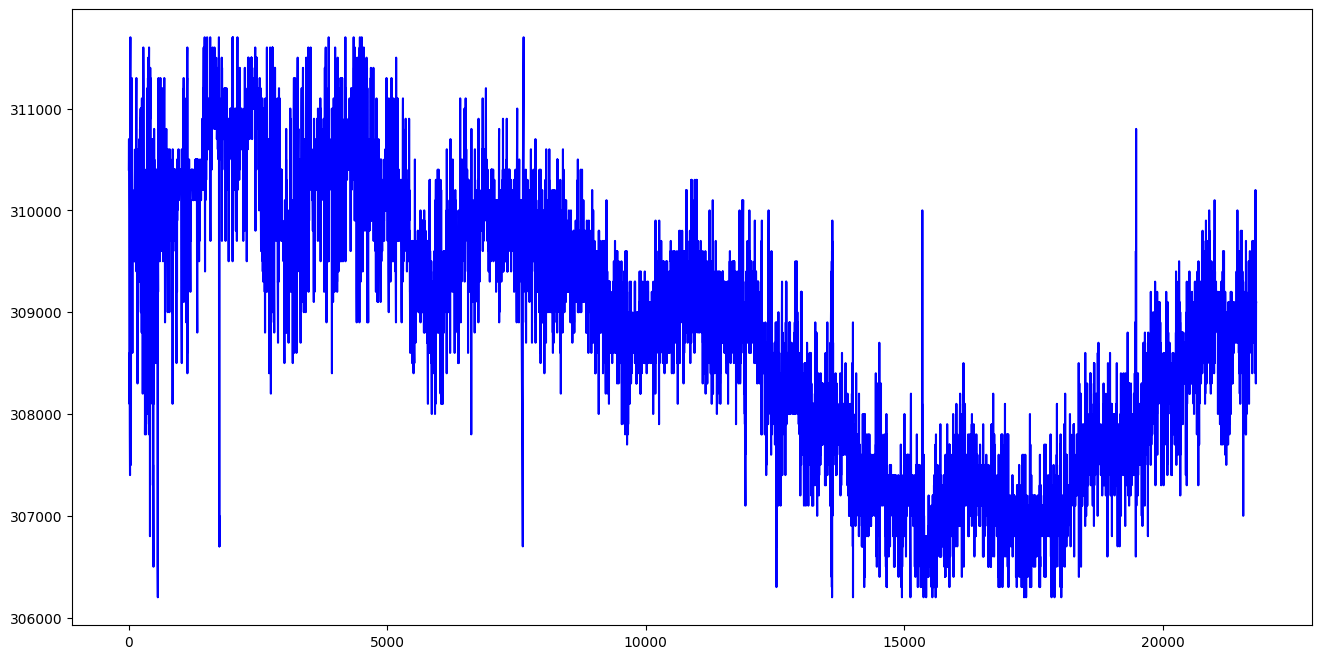

In [ ]:
# Plot the training, actual, and predicted values
plt.figure(figsize=(16, 8))
plt.plot(data.index[:training_data_len], data.values[:training_data_len, 0], label='Training', color='blue')
plt.plot(data.index[training_data_len + 10:training_data_len + 10 + len(predictions[:, 0])], y_test[:, 0], label='Actual', color='orange')
plt.plot(data.index[training_data_len + 10:training_data_len + 10 + len(predictions[:, 0])], predictions[:, 0], label='Predicted', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Training, Actual, and Predicted Stock Prices')
plt.legend()
plt.show()


In [ ]:
# Calculate RMSE and MAPE
rmse = np.sqrt(np.mean((predictions - y_test)**2))
mape = np.mean(np.abs((y_test - predictions) / y_test))

print("RMSE:", rmse)
print("MAPE:", mape)

RMSE: 488.98491932914817
MAPE: 0.0010360960207964562


In [ ]:
print(y_test)
print(predictions)